In [1]:
# current date, for retrieving data from proper location.
year = "2023"
month = "December"
day = "9"

## Imports and initialization

In [2]:
%config Completer.use_jedi = False
import numpy as np 
from scipy.optimize import curve_fit
from numpy import array as arr
import pandas as pd
import plotly.offline as pltly
import scipy.signal
import matplotlib.ticker as ticker
from matplotlib import gridspec
pltly.init_notebook_mode(connected=True)
from plotly import graph_objs as go
import math
import scipy.optimize as opt
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import warnings 
warnings.filterwarnings('module')
warnings.filterwarnings("ignore", category=RuntimeWarning)
from datetime import datetime
import uncertainties.unumpy
import IPython
import pandas as pd
import pickle

from matplotlib.pyplot import *
from matplotlib import rcParams
from matplotlib import style
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# ## set matplotlib plot defaults :D
# Style controls many default colors in matplotlib plots.
# Change the following if you don't like dark backgrounds. Many other options.
import matplotlib as mpl

if False:
    # My Dark Settings
    style.use(['dark_background'])
    c = '#0A0A0A'
    mpl.rcParams['axes.facecolor'] = '#000000'
    mpl.rcParams['figure.edgecolor'] = c
    mpl.rcParams['figure.facecolor'] = c
else:
    # My Light Settings
    style.use(['default'])
    c = '#FFFFFF'
    mpl.rcParams['axes.facecolor'] = c
    mpl.rcParams['figure.edgecolor'] = c
    mpl.rcParams['figure.facecolor'] = c  
# the default cycling of colors in this mode isn't very good.
#rcParams['axes.prop_cycle'] = ("cycler('color', ['r','c','g','#FFFFFF','b']) + cycler('marker', ['o','v','<','>','^'])")
### General
mpl.rcParams['figure.figsize'] = (25.0, 8.0)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['grid.alpha'] = 0.15
mpl.rcParams['axes.formatter.limits'] = (-3,3)
mpl.rcParams['image.cmap'] = 'viridis'
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
mpl.rcParams['font.size'] = 14
viridis = cm.get_cmap('viridis', 256)
dark_viridis = []
color2 = 'tab:blue'
color1 = 'tab:green'
markersize = 10
capsize = 5
bl = 0.15
for i in range(256):
    dark_viridis.append(list(viridis(i)))
    dark_viridis[-1][0] = dark_viridis[-1][0] *(bl+(1-bl)*i/255)
    dark_viridis[-1][1] = dark_viridis[-1][1] *(bl+(1-bl)*i/255)
    dark_viridis[-1][2] = dark_viridis[-1][2] *(bl+(1-bl)*i/255)
dark_viridis_cmap = ListedColormap(dark_viridis)
import mpl_toolkits.axes_grid1
import matplotlib.gridspec as gridspec
from skimage.transform import iradon

In [3]:
import sys
sys.path.append("..")
from Analysis_Python_Files.fitters.Gaussian import dip, double_dip,arb_1d_sum, bump, bump2, bump3, bump2r, gaussian, bump3_Sym, gaussian_2d, poly_nom
from Analysis_Python_Files.fitters.Sinc_Squared import sinc_sq3_Sym, sinc_sq
from Analysis_Python_Files.fitters import decaying_cos, exponential_decay_fixed_limit as decay, linear, LargeBeamMotExpansion, n1State
import Analysis_Python_Files.PictureWindow as pw
import Analysis_Python_Files.ExpFile as exp
exp.setPath(day, month, year)
import Analysis_Python_Files.PlotlyPlotters as pp
import Analysis_Python_Files.MatplotlibPlotters as mp
import Analysis_Python_Files.MatplotlibPlotters_pres as mp_pres
import Analysis_Python_Files.MainAnalysis as ma
import Analysis_Python_Files.AnalysisHelpers as ah
import Analysis_Python_Files.Miscellaneous as misc
import Analysis_Python_Files.PopulationAnalysis as pa
import Analysis_Python_Files.MarksConstants as mc
import Analysis_Python_Files.fitters as fitters
import Analysis_Python_Files.LoadingFunctions as lf
import Analysis_Python_Files.FreeSpaceImaging as fsi
import Analysis_Python_Files.TransferAnalysis as ta
import Analysis_Python_Files.LightShiftCalculations as lsc
import Analysis_Python_Files.CalibrationAnalysis as ca
import Analysis_Python_Files.CollisionalAnalysis as lac
# It's important to explicitly import calPoint here or else pickling doesn't work.
from Analysis_Python_Files.CalibrationAnalysis import calPoint 
from Analysis_Python_Files.TransferAnalysisOptions import TransferAnalysisOptions as ao
import Analysis_Python_Files.ThresholdOptions as to
import Analysis_Python_Files.TransferAnalysisOptions as tao
from importlib import reload
def reloadMyModules(day_=None, month_=None, year_=None):
    reload(exp)
    if day_ is None:
        day_ = day
    if month_ is None:
        month_ = month
    if year_ is None:
        year_ = year
    exp.setPath(day_,month_,year_)
    reload(lf)
    reload(misc)
    reload(ma)
    reload(ah)
    reload(pp)
    reload(mp)
    reload(fitters)
    reload(fsi)
    reload(ta)
    reload(pa)
    reload(tao)
    reload(to)
    reload(ca)
reloadMyModules()

# Today's Work

In [4]:
atomlocs = [2, 2, 3, 3, 1]

In [5]:
loadNone = tao.condition([0,0,0], [0,1,2], [0,0,0])

loadOne = tao.condition([0,0,0], [0,1,2], [1,1,1], numRequired = 1, name = 'Load any one tweezer')
# tao.condition([0 = 1st pic, 1 = 2nd pic],

loadTwo = tao.condition([0,0,0], [0,1,2], [1,1,1], numRequired = 2, name = 'Load any two tweezers')
loadThree = tao.condition([0,0,0], [0,1,2], [1,1,1], numRequired = 3, name = 'Load all three tweezers')
loadOuter = tao.condition([0,0,0], [0,1,2], [1,0,1], numRequired = 2, name = 'Load outer tweezers')

finCenter = tao.condition([1],[1],[1], markerWhichPicList=[1], markerLocList=[1])
# 
# loadOpt= tao.TransferAnalysisOptions(atomlocs, atomlocs, 0,1, [[loadOne], [loadTwo], [loadThree]],[finCenter for _ in range(3)]);
loadOpt= tao.TransferAnalysisOptions(atomlocs, atomlocs, 0,1, [[loadOne], [loadTwo]],[finCenter for _ in range(2)]);
loadOneOpt = tao.TransferAnalysisOptions(atomlocs, atomlocs, 0,1, [[loadOne]],[finCenter for _ in range(1)]);
loadTwoOpt = tao.TransferAnalysisOptions(atomlocs, atomlocs, 0,1, [[loadTwo]],[finCenter for _ in range(1)]);
loadThreeOpt = tao.TransferAnalysisOptions(atomlocs, atomlocs, 0,1, [[loadThree]],[finCenter for _ in range(1)]);
loadOuterOpt = tao.TransferAnalysisOptions(atomlocs, atomlocs, 0,1, [[loadOuter]],[finCenter for _ in range(1)]);

### File 37 (2_0_rate_measurement):  

Number of Pictures: 1600; Picture Dimensions: 5 x 10
Variations: 8;	Repetitions: 100;	Exp File Version: 4;
Experiment started at (H:M:S) 23:20:59: on (Y-M-D) 2023-12-9, And ended at 23:29:27: on 2023-12-9
Experiment Notes:  



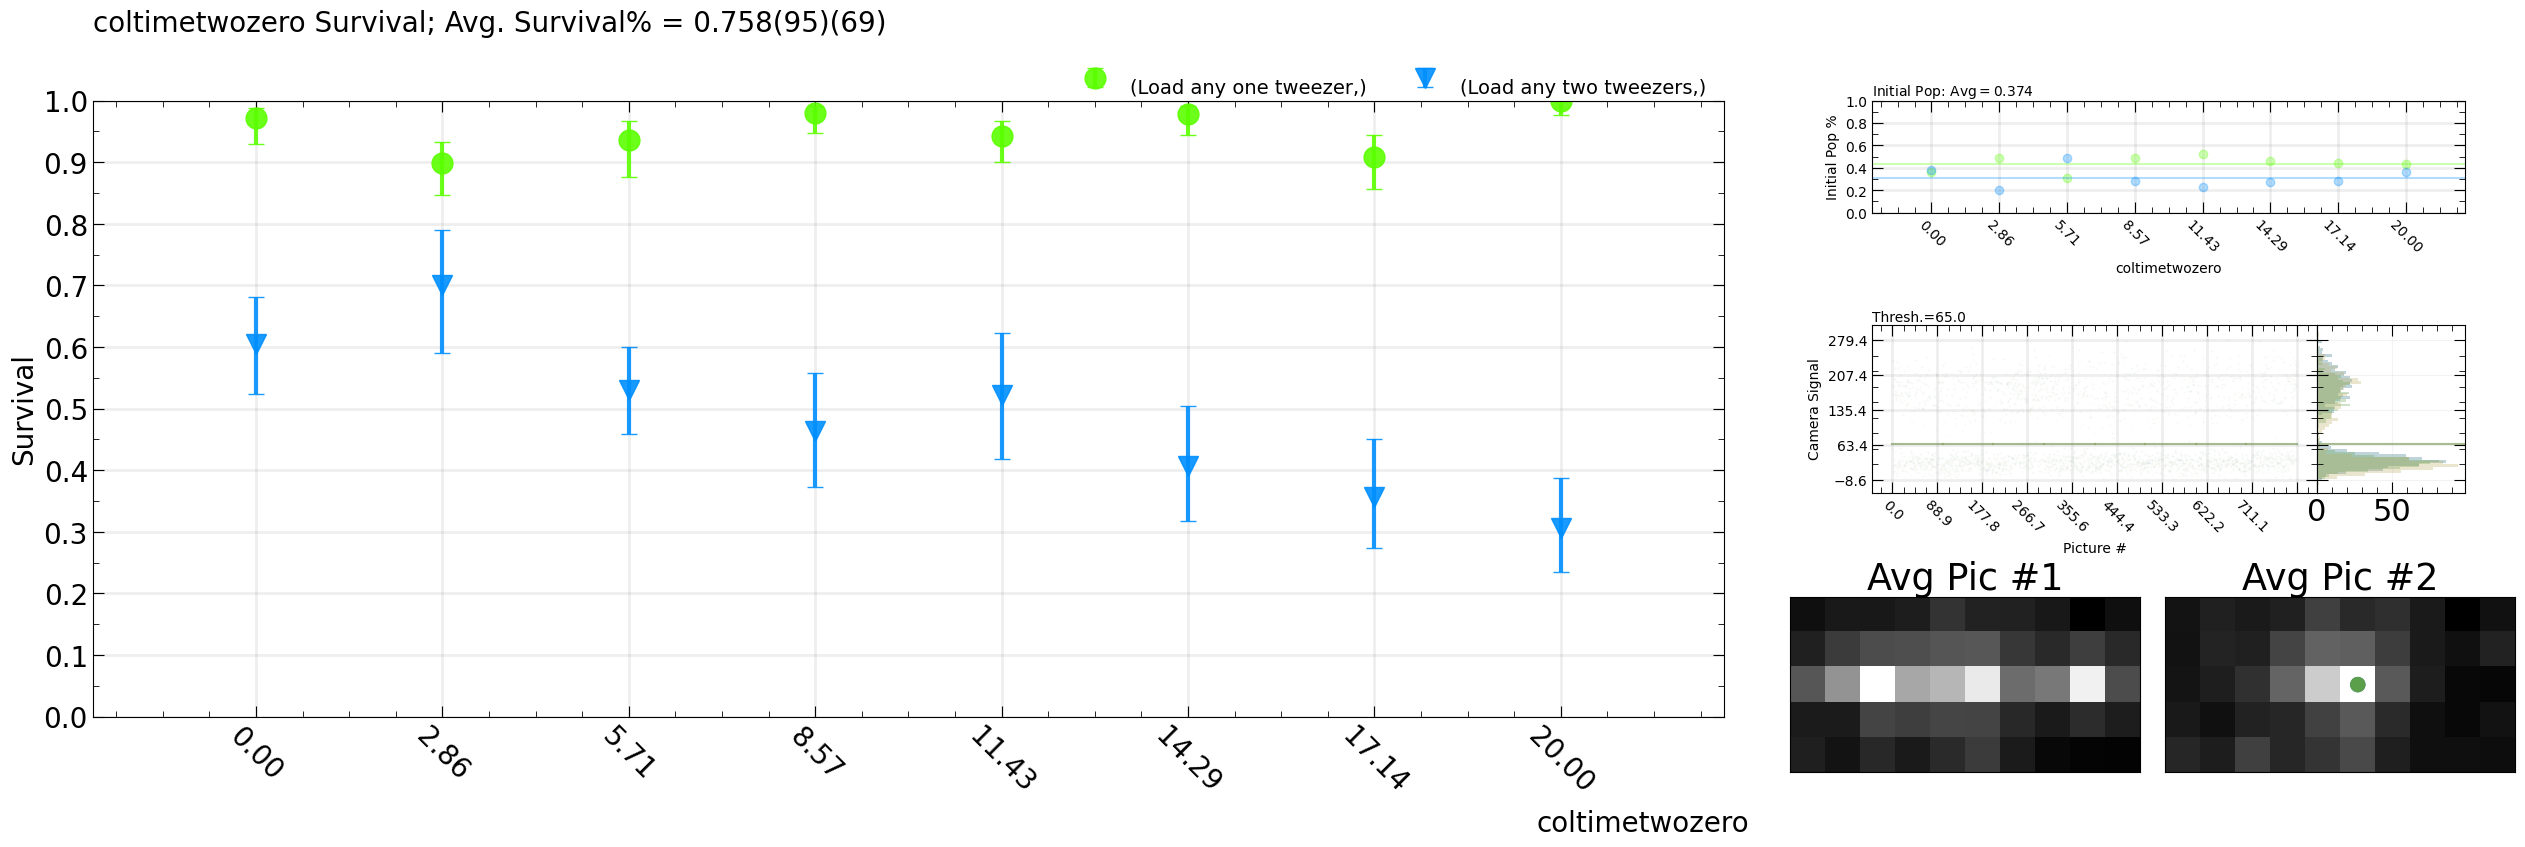

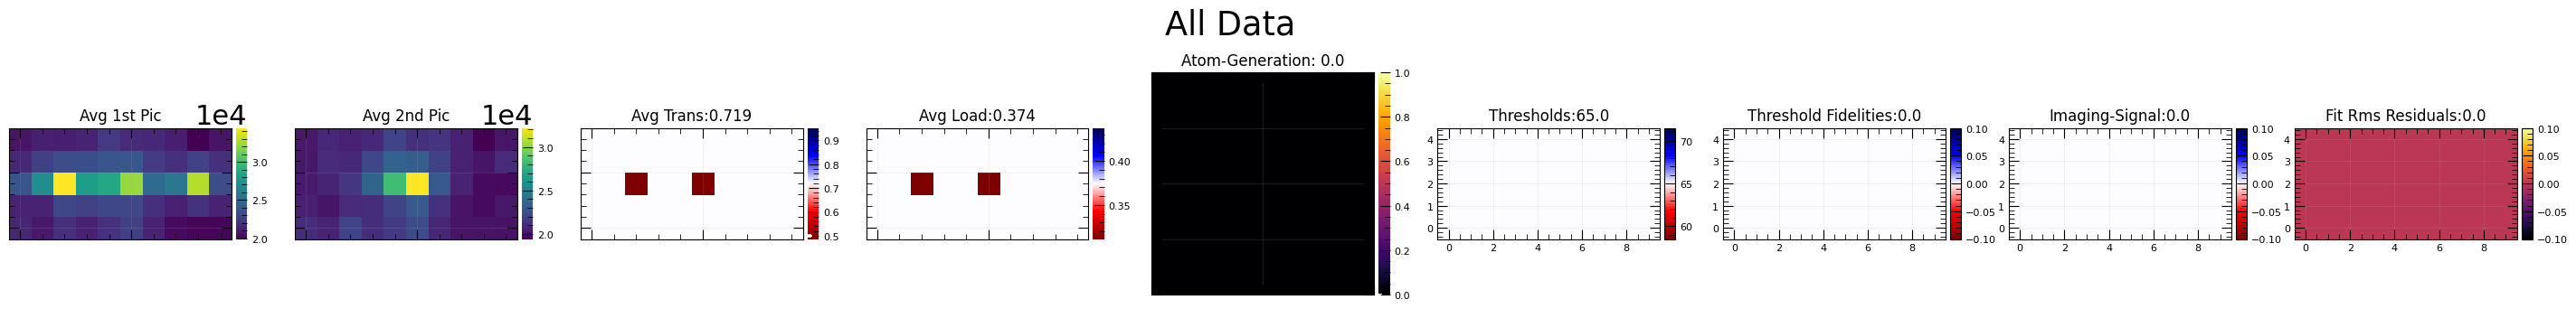

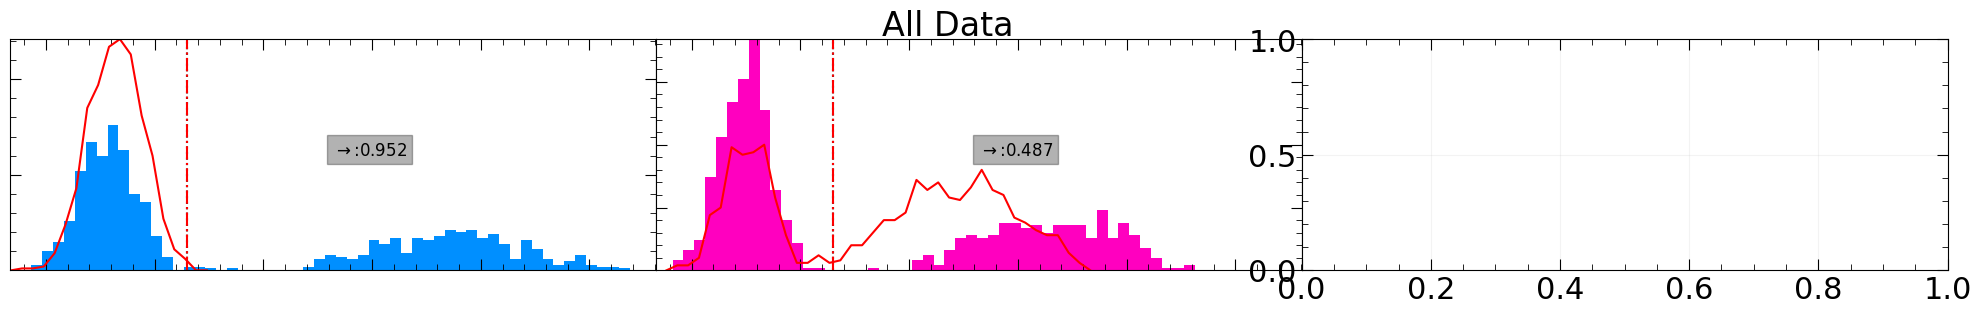

In [84]:
mp.Transfer(37, loadOpt, plotIndvHists = True, plotAvg=False, tOptions = [to.ThresholdOptions(manualThreshold = True, manualThresholdValue = 65)]);

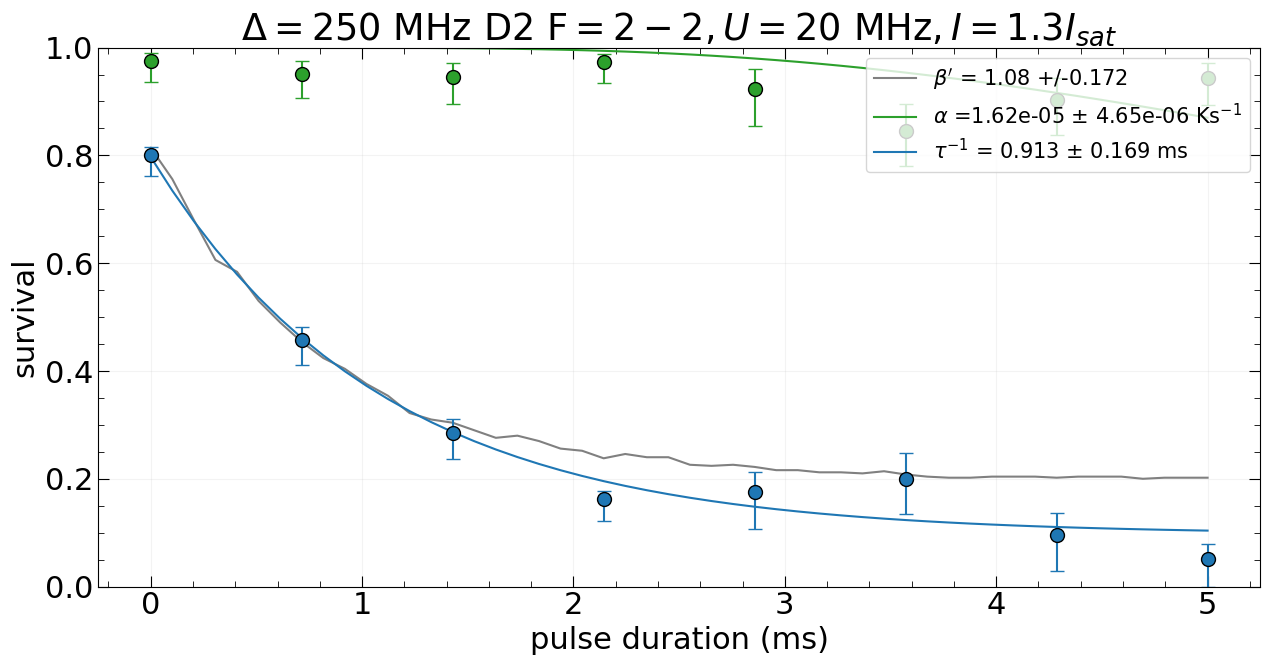

In [47]:
reload(lac)
fileId = 9
threshold = 75
x_data,load_one_y,load_one_err,load_two_y,load_two_err,surv_unc = ta.getCollisionalData(fileId, loadOneOpt,loadTwoOpt,threshold=threshold);
load_two_y[0] = 0.8
num_points = 50
U0=.5e-3
T0=20e-6
alpha_guess = 1e-6
uncertainties = [surv_unc]*num_points # for exponential fit of data
alpha, decay_constant = lac.beta_fit_guess(x_data*1e-6,load_one_y,load_two_y, U0, T0,alpha_guess=alpha_guess,num_points = num_points,plot_alpha=False,plot_tau=False)
_,x_fit,y_fit,unc = lac.decay_fit(x_data,load_two_y,num_points = num_points,plot=False)
beta_prime,high_err,low_err = lac.beta_prime_fit(decay_constant,alpha,uncertainties,x_fit,y_fit,range_lim=2,range_step=0.1)
total_unc = np.sqrt(((high_err+low_err)/2)**2 + unc**2) 

fig,ax = plt.subplots(1, figsize=[15,7])
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
ax.plot(x_fit, lac.two_body_loss_sim(x_fit,beta_prime,alpha), 
        label= f"$\\beta^{{\\prime}}$ = {beta_prime:.2f} +/-{total_unc:.3f} ",color='grey')

ax.errorbar(x_data,load_two_y, yerr=load_two_err,ls='none',ecolor=color2,marker = 'o',markersize = markersize,
            markerfacecolor=color2,markeredgecolor='k',capsize=capsize)


ax.errorbar(x_data,load_one_y, yerr=load_one_err,ls='none',ecolor=color1,marker = 'o',markersize = markersize,
            markerfacecolor=color1,markeredgecolor='k',capsize=capsize)
alpha, decay_constant = lac.beta_fit_guess(x_data*1e-6,load_one_y,load_two_y, U0, T0,alpha_guess=alpha_guess,num_points = num_points)
ticks = np.arange(x_data[0], max(x_data),len(x_data))
plt.legend(loc= 'upper right', ncol = 1,prop={'size': 15})
plt.ylim(0,1)
plt.ylabel('survival')
plt.xlabel(r'pulse duration (ms)')
plt.title(r'$ \Delta = 250 \ \mathrm{MHz} \ \mathrm{D2 \ F=2-2}, U=20 \ \mathrm{MHz}, I=1.3I_{sat} $');

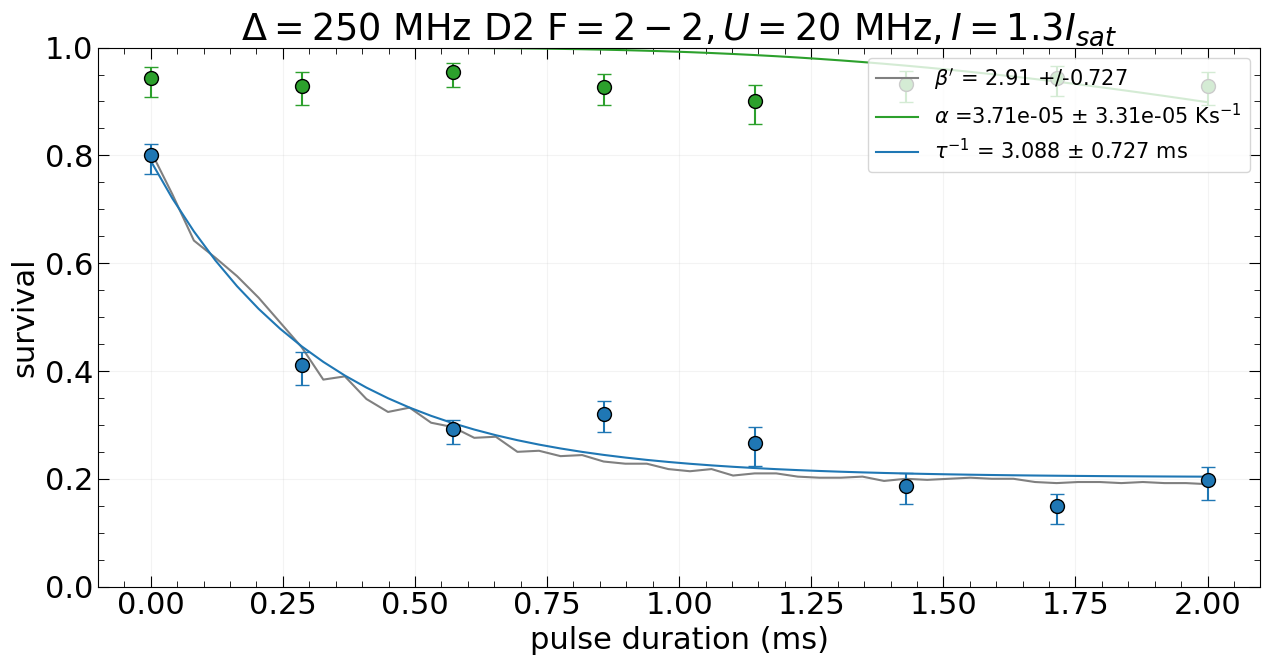

In [56]:
fileId = 23
threshold = 75
x_data,load_one_y,load_one_err,load_two_y,load_two_err,surv_unc = ta.getCollisionalData(fileId, loadOneOpt,loadTwoOpt,threshold=threshold);
load_two_y[0] = 0.8
num_points = 50
U0=.5e-3
T0=20e-6
alpha_guess = 1e-6
uncertainties = [surv_unc]*num_points # for exponential fit of data
alpha, decay_constant = lac.beta_fit_guess(x_data*1e-6,load_one_y,load_two_y, U0, T0,alpha_guess=alpha_guess,num_points = num_points,plot_alpha=False,plot_tau=False)
_,x_fit,y_fit,unc = lac.decay_fit(x_data,load_two_y,num_points = num_points,plot=False)


fig,ax = plt.subplots(1, figsize=[15,7])
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

beta_prime,high_err,low_err = lac.beta_prime_fit(decay_constant,alpha,uncertainties,x_fit,y_fit,range_lim=2,range_step=0.1)
total_unc = np.sqrt(((high_err+low_err)/2)**2 + unc**2) 
ax.plot(x_fit, lac.two_body_loss_sim(x_fit,beta_prime,alpha), 
        label= f"$\\beta^{{\\prime}}$ = {beta_prime:.2f} +/-{total_unc:.3f} ",color='grey')

ax.errorbar(x_data,load_two_y, yerr=load_two_err,ls='none',ecolor=color2,marker = 'o',markersize = markersize,
            markerfacecolor=color2,markeredgecolor='k',capsize=capsize)


ax.errorbar(x_data,load_one_y, yerr=load_one_err,ls='none',ecolor=color1,marker = 'o',markersize = markersize,
            markerfacecolor=color1,markeredgecolor='k',capsize=capsize)
alpha, decay_constant = lac.beta_fit_guess(x_data*1e-6,load_one_y,load_two_y, U0, T0,alpha_guess=alpha_guess,num_points = num_points)
ticks = np.arange(x_data[0], max(x_data),len(x_data))
plt.legend(loc= 'upper right', ncol = 1,prop={'size': 15})
plt.ylim(0,1)
plt.ylabel('survival')
plt.xlabel(r'pulse duration (ms)')
plt.title(r'$ \Delta = 250 \ \mathrm{MHz} \ \mathrm{D2 \ F=2-2}, U=20 \ \mathrm{MHz}, I=1.3I_{sat} $');

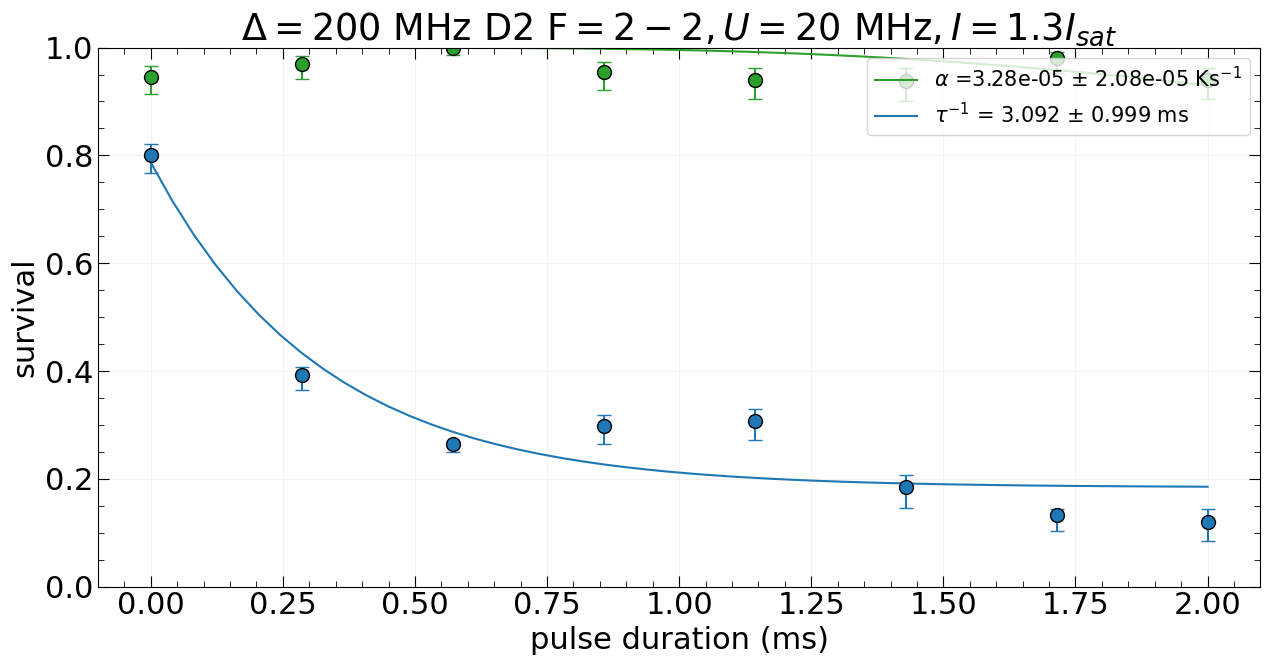

In [57]:
fileId = 24
threshold = 75
x_data,load_one_y,load_one_err,load_two_y,load_two_err,surv_unc = ta.getCollisionalData(fileId, loadOneOpt,loadTwoOpt,threshold=threshold);
load_two_y[0] = 0.8
num_points = 50
U0=.5e-3
T0=20e-6
alpha_guess = 1e-6
uncertainties = [surv_unc]*num_points # for exponential fit of data
alpha, decay_constant = lac.beta_fit_guess(x_data*1e-6,load_one_y,load_two_y, U0, T0,alpha_guess=alpha_guess,num_points = num_points,plot_alpha=False,plot_tau=False)
_,x_fit,y_fit,unc = lac.decay_fit(x_data,load_two_y,num_points = num_points,plot=False)


fig,ax = plt.subplots(1, figsize=[15,7])
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

# beta_prime,high_err,low_err = lac.beta_prime_fit(decay_constant,alpha,uncertainties,x_fit,y_fit,range_lim=2,range_step=0.1)
# total_unc = np.sqrt(((high_err+low_err)/2)**2 + unc**2) 
# ax.plot(x_fit, lac.two_body_loss_sim(x_fit,beta_prime,alpha), 
#         label= f"$\\beta^{{\\prime}}$ = {beta_prime:.2f} +/-{total_unc:.3f} ",color='grey')

ax.errorbar(x_data,load_two_y, yerr=load_two_err,ls='none',ecolor=color2,marker = 'o',markersize = markersize,
            markerfacecolor=color2,markeredgecolor='k',capsize=capsize)


ax.errorbar(x_data,load_one_y, yerr=load_one_err,ls='none',ecolor=color1,marker = 'o',markersize = markersize,
            markerfacecolor=color1,markeredgecolor='k',capsize=capsize)
alpha, decay_constant = lac.beta_fit_guess(x_data*1e-6,load_one_y,load_two_y, U0, T0,alpha_guess=alpha_guess,num_points = num_points)
ticks = np.arange(x_data[0], max(x_data),len(x_data))
plt.legend(loc= 'upper right', ncol = 1,prop={'size': 15})
plt.ylim(0,1)
plt.ylabel('survival')
plt.xlabel(r'pulse duration (ms)')
plt.title(r'$ \Delta = 200 \ \mathrm{MHz} \ \mathrm{D2 \ F=2-2}, U=20 \ \mathrm{MHz}, I=1.3I_{sat} $');

In [75]:
fileId = 26
threshold = 75
x_data,load_one_y,load_one_err,load_two_y,load_two_err,surv_unc = ta.getCollisionalData(fileId, loadOneOpt,loadTwoOpt,threshold=threshold);
load_two_y[0] = 0.8
num_points = 50
U0=.5e-3
T0=20e-6
alpha_guess = 1e-6
uncertainties = [surv_unc]*num_points # for exponential fit of data
alpha, decay_constant = lac.beta_fit_guess(x_data*1e-6,load_one_y,load_two_y, U0, T0,alpha_guess=alpha_guess,num_points = num_points,plot_alpha=False,plot_tau=False)
_,x_fit,y_fit,unc = lac.decay_fit(x_data,load_two_y,num_points = num_points,plot=False)


fig,ax = plt.subplots(1, figsize=[15,7])
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

# beta_prime,high_err,low_err = lac.beta_prime_fit(decay_constant,alpha,uncertainties,x_fit,y_fit,range_lim=2,range_step=0.1)
# total_unc = np.sqrt(((high_err+low_err)/2)**2 + unc**2) 
# ax.plot(x_fit, lac.two_body_loss_sim(x_fit,beta_prime,alpha), 
#         label= f"$\\beta^{{\\prime}}$ = {beta_prime:.2f} +/-{total_unc:.3f} ",color='grey')

ax.errorbar(x_data,load_two_y, yerr=load_two_err,ls='none',ecolor=color2,marker = 'o',markersize = markersize,
            markerfacecolor=color2,markeredgecolor='k',capsize=capsize)


ax.errorbar(x_data,load_one_y, yerr=load_one_err,ls='none',ecolor=color1,marker = 'o',markersize = markersize,
            markerfacecolor=color1,markeredgecolor='k',capsize=capsize)
alpha, decay_constant = lac.beta_fit_guess(x_data*1e-6,load_one_y,load_two_y, U0, T0,alpha_guess=alpha_guess,num_points = num_points)
ticks = np.arange(x_data[0], max(x_data),len(x_data))
plt.legend(loc= 'upper right', ncol = 1,prop={'size': 15})
plt.ylim(0,1)
plt.ylabel('survival')
plt.xlabel(r'pulse duration (ms)')
plt.title(r'$ \Delta = 150 \ \mathrm{MHz} \ \mathrm{D2 \ F=2-2}, U=20 \ \mathrm{MHz}, I=1.3I_{sat} $');

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

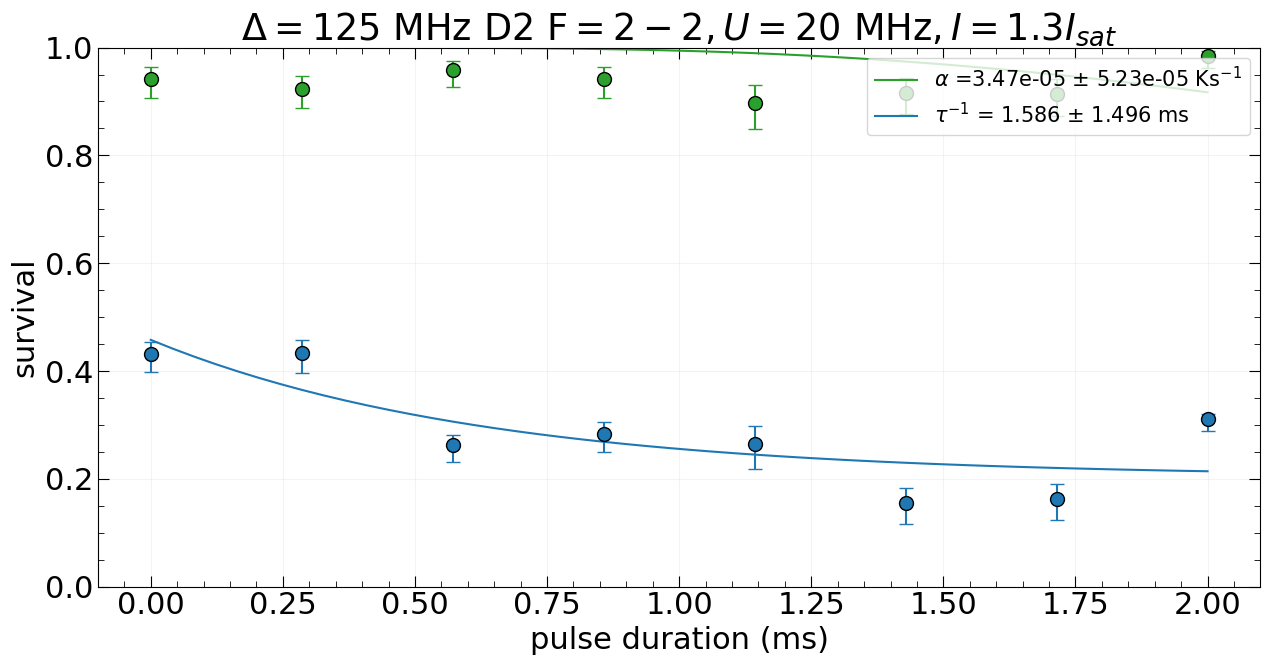

In [74]:
fileId = 28
threshold = 75
x_data,load_one_y,load_one_err,load_two_y,load_two_err,surv_unc = ta.getCollisionalData(fileId, loadOneOpt,loadTwoOpt,threshold=threshold);
load_two_y[0] = 0.8
load_two_y[7] = 0.2
num_points = 50
U0=.5e-3
T0=20e-6
alpha_guess = 1e-6
uncertainties = [surv_unc]*num_points # for exponential fit of data
alpha, decay_constant = lac.beta_fit_guess(x_data*1e-6,load_one_y,load_two_y, U0, T0,alpha_guess=alpha_guess,num_points = num_points,plot_alpha=False,plot_tau=False)
_,x_fit,y_fit,unc = lac.decay_fit(x_data,load_two_y,num_points = num_points,plot=False)


fig,ax = plt.subplots(1, figsize=[15,7])
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

# beta_prime,high_err,low_err = lac.beta_prime_fit(decay_constant,alpha,uncertainties,x_fit,y_fit,range_lim=2,range_step=0.1)
# total_unc = np.sqrt(((high_err+low_err)/2)**2 + unc**2) 
# ax.plot(x_fit, lac.two_body_loss_sim(x_fit,beta_prime,alpha), 
#         label= f"$\\beta^{{\\prime}}$ = {beta_prime:.2f} +/-{total_unc:.3f} ",color='grey')

ax.errorbar(x_data,load_two_y, yerr=load_two_err,ls='none',ecolor=color2,marker = 'o',markersize = markersize,
            markerfacecolor=color2,markeredgecolor='k',capsize=capsize)


ax.errorbar(x_data,load_one_y, yerr=load_one_err,ls='none',ecolor=color1,marker = 'o',markersize = markersize,
            markerfacecolor=color1,markeredgecolor='k',capsize=capsize)
alpha, decay_constant = lac.beta_fit_guess(x_data*1e-6,load_one_y,load_two_y, U0, T0,alpha_guess=alpha_guess,num_points = num_points)
ticks = np.arange(x_data[0], max(x_data),len(x_data))
plt.legend(loc= 'upper right', ncol = 1,prop={'size': 15})
plt.ylim(0,1)
plt.ylabel('survival')
plt.xlabel(r'pulse duration (ms)')
plt.title(r'$ \Delta = 125 \ \mathrm{MHz} \ \mathrm{D2 \ F=2-2}, U=20 \ \mathrm{MHz}, I=1.3I_{sat} $');

In [81]:
fileId = 36
threshold = 75
x_data,load_one_y,load_one_err,load_two_y,load_two_err,surv_unc = ta.getCollisionalData(fileId, loadOneOpt,loadTwoOpt,threshold=threshold);
load_two_y[0] = 0.8
# load_two_y[1] = 0.5
# load_two_y[7] = 0.2
num_points = 50
U0=.5e-3
T0=20e-6
alpha_guess = 1e-6
uncertainties = [surv_unc]*num_points # for exponential fit of data
alpha, decay_constant = lac.beta_fit_guess(x_data*1e-6,load_one_y,load_two_y, U0, T0,alpha_guess=alpha_guess,num_points = num_points,plot_alpha=False,plot_tau=False)
_,x_fit,y_fit,unc = lac.decay_fit(x_data,load_two_y,num_points = num_points,plot=False)


fig,ax = plt.subplots(1, figsize=[15,7])
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

# beta_prime,high_err,low_err = lac.beta_prime_fit(decay_constant,alpha,uncertainties,x_fit,y_fit,range_lim=2,range_step=0.1)
# total_unc = np.sqrt(((high_err+low_err)/2)**2 + unc**2) 
# ax.plot(x_fit, lac.two_body_loss_sim(x_fit,beta_prime,alpha), 
#         label= f"$\\beta^{{\\prime}}$ = {beta_prime:.2f} +/-{total_unc:.3f} ",color='grey')

ax.errorbar(x_data,load_two_y, yerr=load_two_err,ls='none',ecolor=color2,marker = 'o',markersize = markersize,
            markerfacecolor=color2,markeredgecolor='k',capsize=capsize)


ax.errorbar(x_data,load_one_y, yerr=load_one_err,ls='none',ecolor=color1,marker = 'o',markersize = markersize,
            markerfacecolor=color1,markeredgecolor='k',capsize=capsize)
alpha, decay_constant = lac.beta_fit_guess(x_data*1e-6,load_one_y,load_two_y, U0, T0,alpha_guess=alpha_guess,num_points = num_points)
ticks = np.arange(x_data[0], max(x_data),len(x_data))
plt.legend(loc= 'upper right', ncol = 1,prop={'size': 15})
plt.ylim(0,1)
plt.ylabel('survival')
plt.xlabel(r'pulse duration (ms)')
plt.title(r'$ \Delta = 100 \ \mathrm{MHz} \ \mathrm{D2 \ F=2-2}, U=5 \ \mathrm{MHz}, I=1.3I_{sat} $');

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.